# Приоритизация гипотез. А/B тест, анализ и исследование результатов.
Я являюсь аналитиком крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Цели исследования:**  
* Приоритизация гипотез 
* Анализ результатов A/B-теста

**Ход исследования:** 
Ознакомится с данным, приоритизировать имеющиеся гипотезы методом ICE и RICE. Провести анализ полученных результатов А/В-теста, рассмотреть конверсию и средний чек по группам, построить графики, рассмотреть статистические значимости между конверсией и средним чеком групп.

## Анализ и обработка данных

Перед тем как приступить к анализу данных, импортируем библиотеки для работы.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Откроем файлы с данными. 

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv("/datasets/visitors.csv") 

Рассмотрим данные с гипотезами. 

In [3]:
pd.options.display.max_colwidth = 150 
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes




Мы можем заметить, что с данными все в порядке. В них отсутствуют пропуски.

Посмотрим на данные `orders`.

In [ ]:
orders.head()

In [ ]:
orders.info()



В данных отсуствуют пропуски. Колонка с датой представленные типом `object`, для удобной работы с датами, мы измением тип данных. Также мы приведём название колонок к одному виду, и для удобства часть из них переменуем. 

In [7]:
orders['date'] = pd.to_datetime(orders['date'])

orders = orders.rename(columns={'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'})

Посмотрим на данные `visitors`.

In [ ]:
visitors.head()

In [ ]:
visitors.info()


С данными также все хорошо. Дата аналогично, имеет другой тип, его также поменяем.

In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим данные на наличие дубликатов.

In [11]:
print('Количество дубликатов в hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в orders :', orders.duplicated().sum())
print('Количество дубликатов в visitors :', visitors.duplicated().sum())

Количество дубликатов в hypothesis: 0
Количество дубликатов в orders : 0
Количество дубликатов в visitors : 0


Перед тем как закончить с предварительным анализом данных, надо убедиться что результаты А/B теста корректны и все пользователи до конца эксперимента оставались в своей группе.

In [ ]:
check = (orders.pivot_table(index='visitor_id', values='group', aggfunc='nunique'))
check.sort_values('group', ascending=False).head()

Как мы видим часть пользователей, за время эксперимента побывали в двух группах. Чтобы избежать искаженний в наших результатах, мы удалим таких пользователей. И пересохраним полученные результаты.

In [ ]:
check = check[check['group'] != 1]
check = orders[orders['visitor_id'].isin(check.index)].sort_values('visitor_id')
mistakes = check['visitor_id'].unique()
orders = orders[~orders['visitor_id'].isin(mistakes)]
orders

### Вывод

Перед нами качественные данные, с отсуствием пропусков и дубликатов. Для удобства мы изменили название некоторых колонок, привели к общему виду и заменили пробелы нижним слэшем. Колонки с датами мы привели к типу `datetime`. 

В наших данных была часть пользователей, которые попали в обе группы. Чтобы избежать искаженний результатов теста, такие пользователи далее в нашем анализе не участвует.

## Приоритизация гипотез

Посмотрим ещё раз таблицу с гипотезами.

In [14]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Для приоритизации гипотез, мы воспользуемся методами ICE и RICE. 

Для рассчёта ICE мы используем формулу: `Impact * Confidence / Efforts`.
Воспользуемся формулой и отсортируем по убыванию. Посмотрим на первые пять гипотез.

In [15]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(2)
hypothesis[['Hypothesis','ICE']].sort_values('ICE',ascending=False).head()

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00


Перспективной для нас выглядит гипотеза «*запустить акцию, дающую скидку на товар в день рождения*». Но перед тем окончательно сделать выбор посчитаем RICE. Это модификация ICE, где учитывается охват. 

Для рассчёта RICE мы используем формулу: `Reach * Impact * Confidence / Efforts`.
Воспользуемся формулой и отсортируем по убыванию. Посмотрим на первые пять гипотез c учётом полученных значений ICE.

RISE

In [16]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(2)
( 
    hypothesis[['Hypothesis','RICE','ICE']]
    .sort_values('RICE',ascending=False)
    .head()
    .style
    .format({'RICE': '{:.2f}','ICE': '{:.2f}'})
    .background_gradient(cmap='YlGn')
    
)

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20


Как мы видим, гипотеза «*запустить акцию, дающую скидку на товар в день рождения*», оказалась внизу топа. Это связанно с тем, что охват для этой гипотезы низкий. Перспективной сейчас для нас выглядит гипотеза «*добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*». 

### Вывод

Приоритазация гипотез методом ICE и RICE показала нам, что если мы будем рассматривать гипотезу без значений Reach (охват), то выбор подёт на гипотезу «*запустить акцию, дающую скидку на товар в день рождения*». Если для нас будет важен и охват, то стоит рассмотреть гипотезу «*добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*».

## Анализ A/B-теста

У нас имеются результаты A/B-теста, в таблице `orders`и`visitors`. Чтобы исключить "проблему подсматривания" рассмотрим график метрик на примере кумулятивных графиков. Для построения соберём данные. 

В начале создаем массив уникальных пар значений дат и групп теста.

In [17]:
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups.head(4)

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B


Соберём агрегированные кумулятивные по дням данные о заказах.

In [18]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


* date — дата;
* group — группа A/B-теста (A или B);
* orders — кумулятивное количество заказов на указанную дату в указанной группе;
* buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
* revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
* visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

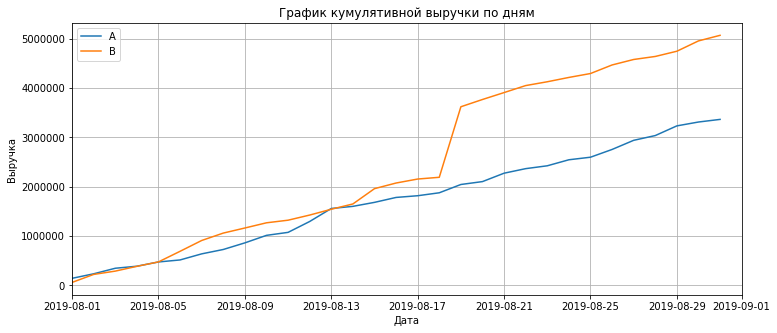

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlim('2019-08-01','2019-09-01')
plt.title('График кумулятивной выручки по дням')
plt.xlabel("Дата")
plt.ylabel('Выручка')
plt.legend()
plt.show()

Графики первые 5 дней вели себя одинаково. Затем мы можем видеть через две недели резкий скачок группы В. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Далее графики ведут себя стабильно. 

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

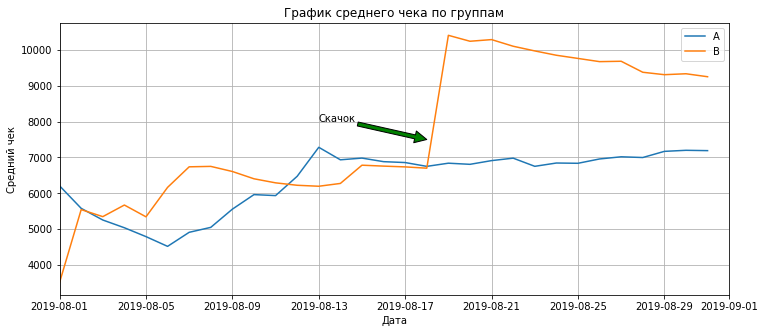

In [20]:
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlim('2019-08-01','2019-09-01')
plt.title('График среднего чека по группам')
plt.xlabel("Дата")
plt.ylabel('Средний чек')
plt.annotate('Скачок', xy=('2019-08-18', 7500), xytext=('2019-08-13', 8000),
            arrowprops=dict(facecolor='g'))
plt.legend()
plt.show()

Видно на графике, что значения ведут себя скачкаобразно. Для группы А, значение первые 5 дней падают, затем растут. После второй недели незначительно падают, но начинают выравниваться. 
Для группы B, виден скачок после 17ого числа (возможно попал крупный заказ), затем начинается падание. Видно что график пока что не выровнился и требуется больше времени.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

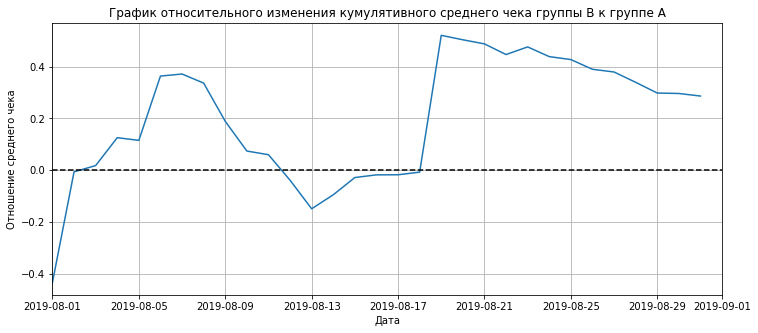

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))
plt.grid()
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlim('2019-08-01','2019-09-01')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel("Дата")
plt.ylabel('Отношение среднего чека')
plt.show()

На графике видны резкие скачки, что можно интерпретировать как наличие выбросов в нашем тесте. Зафиксируем информацию и вернёмся к ней позже. 

Построем график кумулятивной конверсии по группам.

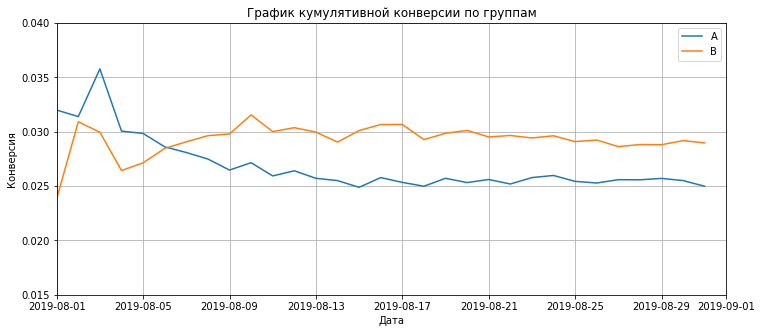

In [22]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивной конверсии по группам')
plt.xlabel("Дата")
plt.ylabel('Конверсия')
plt.axis(["2019-08-01", '2019-09-01', 0.015, 0.040]) 
plt.legend()
plt.show()

Из графика можно увидеть, что конверсии групп примерно одинаково себя вела, через пару дней от начала теста, группа B начала расти, а группа А падать. При этом конверсия группы А зафиксировалась, раньше группы B.

Посмотирм на график относительного изменения кумулятивной конверсии группы B к группе A.

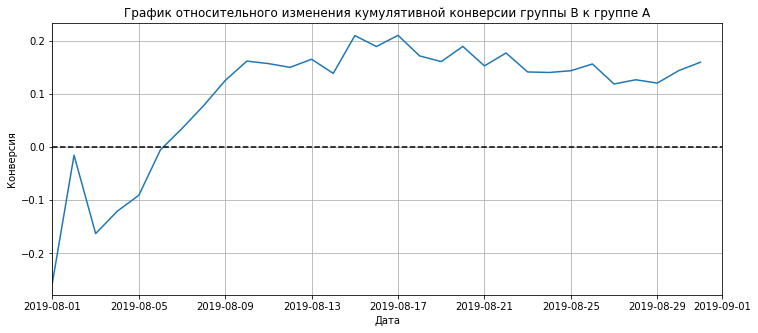

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.xlim('2019-08-01','2019-09-01')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel("Дата")
plt.ylabel('Конверсия')

plt.show()

По графику видно, что первые дни конверсия для группы А была выше, случился скачок в сторону B. На пятый день случился резкий рост конверсии группы B, и можно заметить что значение не идёт на спад. 

Мы знаем, что в нашем тесте находятся аномальные значения, которые могут вносить большой вклад в наши расчёты. Попробуем посмотреть какие именно значения являются аномальными, а какие нет.

Подсчитаем количество заказов по пользователям.

In [24]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']
ordersByUsers.head(5).sort_values('user_id')

,user_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


Построим точечный график количества заказов по пользователям.

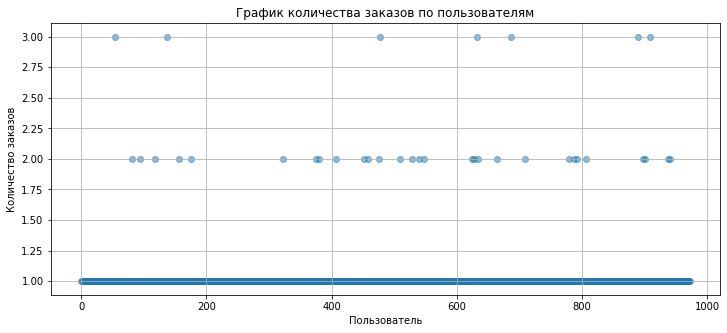

In [25]:
x_values = pd.Series(range(0,len(ordersByUsers)))


plt.figure(figsize=(12,5))
plt.grid()
plt.scatter(x_values, ordersByUsers['orders'],alpha=0.5) 
plt.title('График количества заказов по пользователям')
plt.xlabel("Пользователь")
plt.ylabel('Количество заказов')
plt.show()

По графику мы можем видеть: 
* большая часть пользователей не делают больше одного заказа
* малая часть делает 2 заказа
* заказов делают не больше 3

Для большей точности, мы можем разбить выборку по количеству заказов на перцентили.

In [26]:
print('95-тый перцентиль количества заказов на пользователя:', (np.percentile(ordersByUsers['orders'], 95))) 
print('99-тый перцентиль количества заказов на пользователя:', (np.percentile(ordersByUsers['orders'], 99))) 

95-тый перцентиль количества заказов на пользователя: 1.0
99-тый перцентиль количества заказов на пользователя: 2.0


Не более 5% всех пользователей делают больше одного заказа, и лишь 1% может сделать 2 и более заказов. Будем считать такие значения как выбросы. За нижнюю границу количество заказов примем значение больше 1. 

Проделаем, тоже самое для среднего чека и построим точечный график стоимостей заказов.

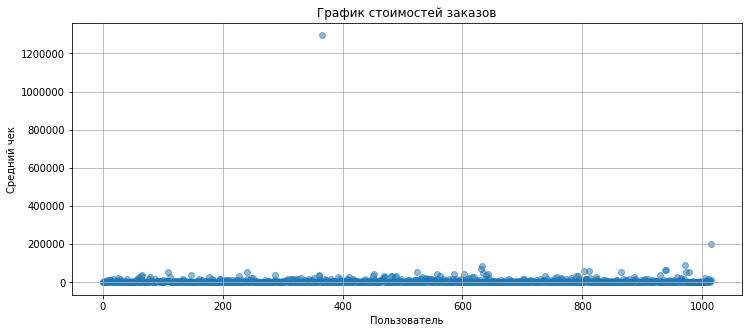

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,5))
plt.grid()
plt.scatter(x_values, orders['revenue'],alpha=0.5) 
plt.title('График стоимостей заказов')
plt.xlabel("Пользователь")
plt.ylabel('Средний чек')
plt.show()

По графику видно:
* средний чек основной части пользователей ниже 50000, из-за масштабов примерно 
* мы можем увидеть явные выбросы: точка в значении 1200000 

Рассмотрим перцентили:

In [28]:
print('95-тый перцентиль среднего чека:', (np.percentile(orders['revenue'], 95).round(2))) 
print('99-тый перцентиль среднего чека:', (np.percentile(orders['revenue'], 99).round(2))) 

95-тый перцентиль среднего чека: 26785.0
99-тый перцентиль среднего чека: 53904.0


Лишь у 1% пользователей средний чек вышел 53904, что говорит нам что точки 200000 и 1200000 это точно выбросы, которые мы не будем учитывать. За нижнюю границу мы примем пользоваталей, чей средний чек не превышает 26785.

Установив границы аномальных значений, посчитаем статистическую значимость различий в конверсии между группами по "сырым" , а затем по "отфильтрованным" данным. 

In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

#количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей до выбранной даты включительно в группе B.
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#суммарное число заказов до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#суммарное количество заказов до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

df = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

df.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


* ordersPerDateA — количество заказов в выбранную дату в группе A;
* revenuePerDateA — суммарная выручка в выбранную дату в группе A;
* ordersPerDateB — количество заказов в выбранную дату в группе B;
* revenuePerDateB — суммарная выручка в выбранную дату в группе B;
* ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
* revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
* ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
* revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
* visitorsPerDateA — количество пользователей в выбранную дату в группе A;
* visitorsPerDateB — количество пользователей в выбранную дату в группе B;
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Статистическую значимость различий конверсии, мы будем считать через критерий Манна-Уитни. С помощью полученного p-value, мы будем принимать или отвергать гипотезы:
* За нулевую гипотезу примем: *конверсия группы А и B равна между собой*;
* Альтернативная гипотеза: *конверсия группы А и В отличаются друг от друга*.

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsersB.columns = ['user_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
p_value = stats.mannwhitneyu(sampleA, sampleB, True,'two-sided')[1]
print("P-value: {0:.3f}".format(p_value))
if p_value < 0.05:
    print('Мы не можем принять нулевую гипотезу')
else:
    print('Мы принимаем нулевую гипотезу')

print("Прирост конверсии группы B : {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.011
Мы не можем принять нулевую гипотезу
Прирост конверсии группы B : 0.160


Полученные данные говорят нам отклонить нулевую гипотезу, а значит конверсия группы А и В не равна между собой. Конверсия группы B выше группы А на 16%

Теперь попробуем проверить гипотезы: 
* *средний чек между группой А и В равны между собой* будет нулевой гипотезой;
* *средний чек между группой А и В отличается* будет альтернативной гипотезой.

In [31]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],True,'two-sided')[1]
print("P-value: {0:.3f}".format(p_value))
if p_value < 0.05:
    print('Мы не можем принять нулевую гипотезу')
else:
    print('Мы принимаем нулевую гипотезу')

print('Относительные различия в среднем чеке между группами: {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Мы принимаем нулевую гипотезу
Относительные различия в среднем чеке между группами: 0.287


Полученные данные говорят нам о том, что средний чек между группой А и В равны между собой. Хотя разница в среднем чеке в группах в районе ~28.7%. 

Чтобы посмотреть, значения без аномалей, посчитаем количество таких пользователей. напомню что количество заказов таких пользователей больше одного, а средний чек превышает 26785.

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(f'Количество "аномальных" пользователей: {len(abnormalUsers)}') 

Количество "аномальных" пользователей: 86


Используя полученную таблицу с выбросами, посмотрим на "очищенные данные". Также посмотрим на конверсию, нулевая гипотеза остатётся у нас такой же: конверсия группы А и B равна между собой. 

In [33]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered,True,'two-sided')[1]
print("P-value: {0:.3f}".format(p_value))
if p_value < 0.05:
    print('Мы не можем принять нулевую гипотезу')
else:
    print('Мы принимаем нулевую гипотезу')

print('Прирост конверсии группы B : {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.016
Мы не можем принять нулевую гипотезу
Прирост конверсии группы B : 0.174


Гипотеза также была отвергнута. А прирост конверсии даже повысился! 

Рассмотрим аналогично для среднего чека, гипотеза которую мы проверяем: средний чек между группой А и В равны между собой.

In [34]:
p_value = stats.mannwhitneyu(
    orders[np.logical_and( orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],True,'two-sided'
        )[1]
    
print("P-value: {0:.3f}".format(p_value))
if p_value < 0.05:
    print('Мы не можем принять нулевую гипотезу')
else:
    print('Мы принимаем нулевую гипотезу')

print(
    "Относительные различия в среднем чеке между группами: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.727
Мы принимаем нулевую гипотезу
Относительные различия в среднем чеке между группами: -0.034


Значение p-value немного уменьшилась, но все ещё нулевая гипотеза не отвергается. Относительные различия в среднем чеке между группами уменьшилось до 0! Это отличие от "сырых данных", показывает как сильно повлияли аномальные пользователи на наш тест.

## Общий вывод

Мы ознакомились с данными, обработали их и удалили пользователей который попали в обе группы, что искажает общий результат теста. 

Из приоритизированных гипотез выделим "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" рассчитаная с учетом охвата и посчитана методом RICE и "запустить акцию, дающую скидку на товар в день рождения" полученная из формулы ICE. 


Результаты анализа А/В-теста:  
* Наблюдается статистически значимое различие по конверсии между группами; 
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* График различия конверсии между группами показывает, что результаты группы А хуже группы В и нет значительной тенденции к улучшению;
* Из графика различия среднего чека видно, что разница между группами по "сырым данным" около 28%, по отфильтрованным данным разница около нуля.

Из полученных статистических значений различий и графиков, мы можем наблюдать успех группы B на А, поэтому самым экономически выгодным и оправданным решением будет, закончить тест победой группы B.